In [1]:
# set to false when no multiprocessing is available
if True:
    import multiprocess as mp
    cpus = 20
    mp.set_start_method("spawn")

In [2]:
#import libraries
import scipy
import seaborn as sns
import matplotlib.font_manager as font_manager
import matplotlib
from mpl_toolkits.axes_grid1.inset_locator import InsetPosition
from scipy.stats import sem
import numpy as np
import hmp 
import xarray as xr
import matplotlib.pyplot as plt
import os
from mne.io import read_info
from datetime import datetime
from statsmodels.stats.descriptivestats import sign_test 
from scipy.stats import ttest_1samp

# get EEG information
epoch_data_path = os.path.join('data/subjects/')                                        #Declaring path where the eeg data is
subj_names = [x.split('.')[0] for x in os.listdir(epoch_data_path) if 'epo.fif' in x]   #Extracting subject name based on the file name
subj_files = [epoch_data_path+x+'.fif' for x in subj_names]                             #Create a list of files that can be read from the folder
info = read_info(subj_files[0], verbose=False)

# load the epoched data and convert to hmp data applying PCA
epoch_data =  hmp.utils.load_data('data/hmp_data/epoch_data.nc')
hmp_data = hmp.utils.transform_data(epoch_data, n_comp=4)

In [3]:
def get_estimates(shape, location_corr_threshold, location_corr_duration, condition = None):
    # this if-else-statement only makes the loop execute the model without custom parameters once instead of three times
    if location_corr_threshold == "None" and location_corr_duration != "200":
        return []

    else:
        if condition:
            path_name = "results/conditional/" + condition + "/shape" + str(shape) + \
                        "/location_corr_threshold" + str(location_corr_threshold) + \
                        "/location_corr_duration" + str(location_corr_duration)
        else:
            path_name = "results/general/shape" + str(shape) + \
                        "/location_corr_threshold" + str(location_corr_threshold) + \
                        "/location_corr_duration" + str(location_corr_duration)
        
        return [
            xr.open_dataset(path_name + "/estimates[0].nc"),
            [xr.open_dataset(path_name + "/estimates[1][{0}].nc".format(i)) for i in range (0, 40)]
        ]

In [4]:
def compare_models(likehoods1, likehoods2):
    # check if likelihoods of model 1 are significantly higher than that of model 2.
    diffs = likehoods1 - likehoods2
    print("means: ", round(np.nanmean(likehoods1), 1), round(np.nanmean(likehoods2), 1))
    print("SD:     ", round(np.nanstd(likehoods1), 1), round(np.nanstd(likehoods2), 1))
    print("t-test: ", ttest_1samp(diffs, 0, alternative='greater'))

In [5]:
def get_likelihoods(estimates, events):
    return estimates[0]["loo_likelihood"].sel(n_event=events).data

In [6]:
def show_boxplot(likelihoods):
    plt.boxplot(likelihoods)

In [7]:
def sum_likelihoods(model1, model2, model3, model4):
    likelihoods_sum = np.zeros(40)
    for model in [model1, model2, model3, model4]:
        likelihoods_sum += model
    return likelihoods_sum

In [8]:
general_model_2_None_200 = get_likelihoods(get_estimates(2, None, 200), 3)
general_model_4_None_200 = get_likelihoods(get_estimates(4, None, 200), 3)
general_model_6_None_200 = get_likelihoods(get_estimates(6, None, 200), 6)

In [9]:
conditional_model_2_None_200_A = get_likelihoods(get_estimates(2, None, 200, "A"), 4)
conditional_model_2_None_200_B = get_likelihoods(get_estimates(2, None, 200, "B"), 3)
conditional_model_2_None_200_C = get_likelihoods(get_estimates(2, None, 200, "C"), 5)
conditional_model_2_None_200_D = get_likelihoods(get_estimates(2, None, 200, "D"), 4)

conditional_model_4_None_200_A = get_likelihoods(get_estimates(4, None, 200, "A"), 4)
conditional_model_4_None_200_B = get_likelihoods(get_estimates(4, None, 200, "B"), 3)
conditional_model_4_None_200_C = get_likelihoods(get_estimates(4, None, 200, "C"), 6)
conditional_model_4_None_200_D = get_likelihoods(get_estimates(4, None, 200, "D"), 4)

conditional_model_6_None_200_A = get_likelihoods(get_estimates(6, None, 200, "A"), 6)
conditional_model_6_None_200_B = get_likelihoods(get_estimates(6, None, 200, "B"), 4)
conditional_model_6_None_200_C = get_likelihoods(get_estimates(6, None, 200, "C"), 4)
conditional_model_6_None_200_D = get_likelihoods(get_estimates(6, None, 200, "D"), 5)

In [10]:
conditional_model_2_None_200 = sum_likelihoods(
    conditional_model_2_None_200_A,
    conditional_model_2_None_200_B,
    conditional_model_2_None_200_C,
    conditional_model_2_None_200_D
)

conditional_model_4_None_200 = sum_likelihoods(
    conditional_model_4_None_200_A,
    conditional_model_4_None_200_B,
    conditional_model_4_None_200_C,
    conditional_model_4_None_200_D
)

conditional_model_6_None_200 = sum_likelihoods(
    conditional_model_6_None_200_A,
    conditional_model_6_None_200_B,
    conditional_model_6_None_200_C,
    conditional_model_6_None_200_D
)

In [11]:
compare_models(conditional_model_2_None_200, general_model_2_None_200)

means:  -84.2 -102.8
SD:      125.8 109.1
t-test:  TtestResult(statistic=3.597259745316848, pvalue=0.00044683034834969154, df=39)


In [12]:
compare_models(general_model_2_None_200, general_model_6_None_200)

means:  -102.8 -110.5
SD:      109.1 121.5
t-test:  TtestResult(statistic=0.7071636114843712, pvalue=0.24183458216177506, df=39)


In [13]:
compare_models(conditional_model_4_None_200, general_model_4_None_200)

means:  -109.4 -129.6
SD:      114.4 106.7
t-test:  TtestResult(statistic=3.537043208204111, pvalue=0.0005310997713588498, df=39)


In [14]:
def general_loocv_model(init, mags, params, e):
    #fit final model
    return init.fit_single(e, magnitudes=mags,parameters=params)

In [15]:
def cond_loocv_model(init, mags, pars, mapping, e):
    conds = {'event_name': ['A', 'B', 'C', 'D']} 

    if mapping == "full" or e == 3:
        # assuming that the number of events is 3
        mags_map = np.swapaxes(np.array([[1, 2, 3, 4]] * e), 0, 1)
        pars_map = np.swapaxes(np.array([[1, 2, 3, 4]] * (e + 1)), 0, 1)

    elif mapping == "half" and e != 3:
        # assuming that the number of events is 6
        mags_map = np.array([[0, 0, 0, 0, 0, 0],
                             [0, 0, 1, 0, 0, 0],
                             [0, 0, 2, 1, 1, 0],
                             [0, 0, 3, 1, 1, 0]])

        pars_map = np.array([[0, 0, 0, 0, 0, 0, 0],
                             [0, 0, 1, 0, 0, 0, 0],
                             [0, 0, 2, 1, 1, 0, 0],
                             [0, 0, 3, 1, 1, 0, 0]])
    
    return init.fit_single_conds(magnitudes=mags, parameters=pars, mags_map=mags_map, pars_map=pars_map, conds=conds, verbose=False)

In [16]:
def get_mags_pars(models, e):
    #get average mags and params
    mags = models[0].sel(n_events=e).magnitudes.dropna('event')
    params = models[0].sel(n_events=e).parameters.dropna('stage')

    participants = pp = len(np.unique(models[0].participant.values))
    for pp in range(1, participants):
        mags += models[pp].sel(n_events=e).magnitudes.dropna('event')
        params += models[pp].sel(n_events=e).parameters.dropna('stage')
    mags = mags / participants
    params = params / participants

    return mags, params

In [17]:
init = hmp.models.hmp(hmp_data, epoch_data, event_width=50, cpus=cpus, 
                                            shape =                   2,
                                            location_corr_threshold = None,
                                            location_corr_duration  = 200)

max_events = 3

estimates = get_estimates(2, None, 200)
mags, params = get_mags_pars(estimates[1], max_events)

# fit general model
general_model = general_loocv_model(init, mags, params, max_events)

# fit condition models
full_cond_model = cond_loocv_model(init, mags, params, "full", max_events)
half_cond_model = cond_loocv_model(init, mags, params, "half", max_events)

Estimating 3 events model
parameters estimated for 3 events model


In [18]:
# general_model_likelihoods = hmp.loocv.loocv(init, hmp_data, general_model, cpus = cpus, verbose = False)
general_model_likelihoods = hmp.loocv.loocv_func(init, hmp_data, general_loocv_model, func_args = [mags, params, max_events], cpus = cpus, verbose = False)
full_cond_likelihoods = hmp.loocv.loocv_func(init, hmp_data, cond_loocv_model, func_args = [mags, params, "full", max_events], cpus = cpus, verbose = False)
half_cond_likelihoods = hmp.loocv.loocv_func(init, hmp_data, cond_loocv_model, func_args = [mags, params, "half", max_events], cpus = cpus, verbose = False)

We recommend using cpus==1 unless you have *a lot* of memory and cpus available.
Estimating 3 events model
Estimating 3 events model
parameters estimated for 3 events model
Estimating 3 events model
parameters estimated for 3 events model
Estimating 3 events model
parameters estimated for 3 events model
Estimating 3 events model
parameters estimated for 3 events model
Estimating 3 events model
parameters estimated for 3 events model
Estimating 3 events model
parameters estimated for 3 events model
Estimating 3 events model
parameters estimated for 3 events model
Estimating 3 events model
parameters estimated for 3 events model
Estimating 3 events model
parameters estimated for 3 events model
Estimating 3 events model
parameters estimated for 3 events model
Estimating 3 events model
parameters estimated for 3 events model
Estimating 3 events model
parameters estimated for 3 events model
Estimating 3 events model
parameters estimated for 3 events model
Estimating 3 events model
parameter

In [19]:
likelihoods_sum = np.zeros(40)

for condition, max_events in zip(['A', 'B', 'C', 'D'], [4, 3, 5, 4]):

    estimates = get_estimates(2, None, 200, condition)
    mags, params = get_mags_pars(estimates[1], max_events)

    hmp_data_cond = hmp.utils.condition_selection(hmp_data, epoch_data, condition, variable='event_name')

    init = hmp.models.hmp(hmp_data_cond, epoch_data, event_width=50, cpus=cpus, 
                                                    shape =                   2,
                                                    location_corr_threshold = None,
                                                    location_corr_duration  = 200)

    cond_model = general_loocv_model(init, mags, params, max_events)
    cond_model_likelihoods = hmp.loocv.loocv_func(init, hmp_data_cond, general_loocv_model, func_args = [mags, params, max_events], cpus = cpus, verbose = False)
    likelihoods_sum += cond_model_likelihoods[0]


Estimating 4 events model
parameters estimated for 4 events model
We recommend using cpus==1 unless you have *a lot* of memory and cpus available.
Estimating 4 events model
Estimating 4 events model
Estimating 4 events model
parameters estimated for 4 events model
Estimating 4 events model
parameters estimated for 4 events model
Estimating 4 events model
parameters estimated for 4 events model
parameters estimated for 4 events model
Estimating 4 events model
Estimating 4 events model
parameters estimated for 4 events model
Estimating 4 events model
parameters estimated for 4 events model
Estimating 4 events model
parameters estimated for 4 events model
Estimating 4 events model
parameters estimated for 4 events model
Estimating 4 events model
parameters estimated for 4 events model
Estimating 4 events model
parameters estimated for 4 events model
Estimating 4 events model
Estimating 4 events model
parameters estimated for 4 events model
parameters estimated for 4 events model
parameter

In [20]:
compare_models(likelihoods_sum, full_cond_likelihoods[0])

means:  -83.2 -102.7
SD:      125.9 109.4
t-test:  TtestResult(statistic=3.792128818098866, pvalue=0.00025353840613277003, df=39)


In [21]:
compare_models(likelihoods_sum, general_model_likelihoods[0])

means:  -83.2 -101.9
SD:      125.9 109.3
t-test:  TtestResult(statistic=3.602214206287007, pvalue=0.0004405011028363565, df=39)


In [22]:
compare_models(full_cond_likelihoods[0], general_model_likelihoods[0])

means:  -102.7 -101.9
SD:      109.4 109.3
t-test:  TtestResult(statistic=-2.027720871395853, pvalue=0.975269863543184, df=39)


/tmp/ipykernel_1952316/3567997669.py:14: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(['General Model', 'Adapted General Model', "Conditional Model"])


{'whiskers': [<matplotlib.lines.Line2D at 0x7f7df0e49fd0>,
 'caps': [<matplotlib.lines.Line2D at 0x7f7df0e4aab0>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f7df1869bb0>,
 'medians': [<matplotlib.lines.Line2D at 0x7f7df0e48ad0>,
 'fliers': [<matplotlib.lines.Line2D at 0x7f7df0f84e00>,
 'means': []}

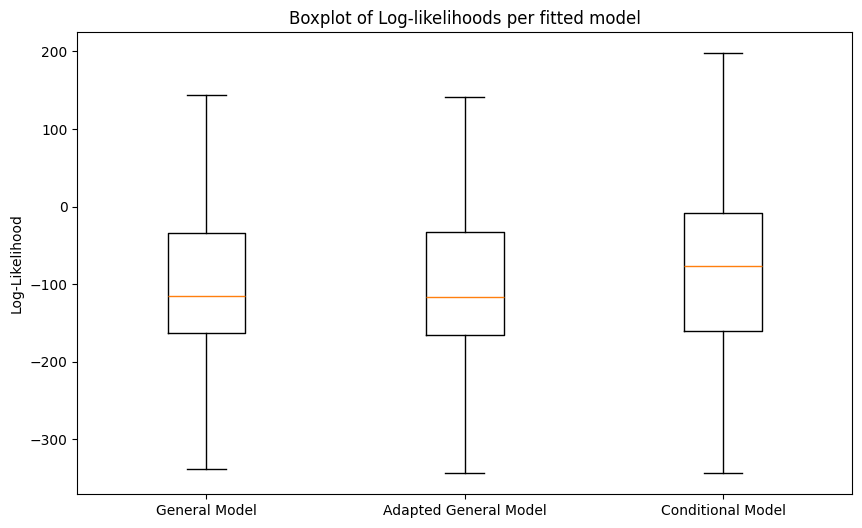

In [23]:
all_likelihoods = [general_model_likelihoods[0],
                   full_cond_likelihoods[0],
                   likelihoods_sum]

fig, ax1 = plt.subplots(figsize=(10, 6))

ax1.set(
    
    title='Boxplot of Log-likelihoods per fitted model',
    ylabel='Log-Likelihood',
)

# x-axis labels
ax1.set_xticklabels(['General Model', 'Adapted General Model', "Conditional Model"])
plt.boxplot(all_likelihoods)

In [24]:
def plot_event_probs(estimates, max_events):
    plt.plot(estimates.eventprobs.mean('trial_x_participant'), label=range(1, max_events + 1))
    plt.ylabel('P(event)')
    plt.xlabel('Time (sample)')
    plt.legend()
    plt.show()

2 None
Estimating 5 events model
parameters estimated for 5 events model


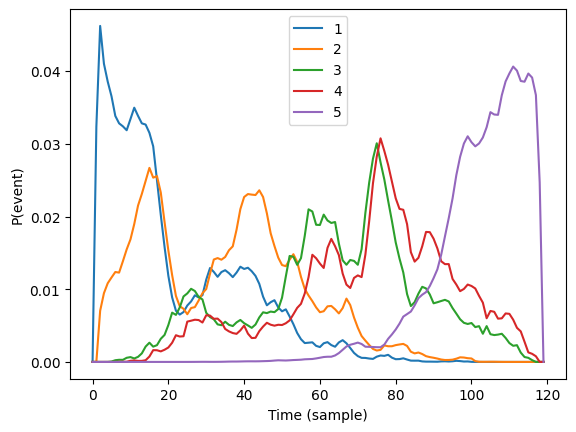

2 0.4
Estimating 5 events model
parameters estimated for 5 events model


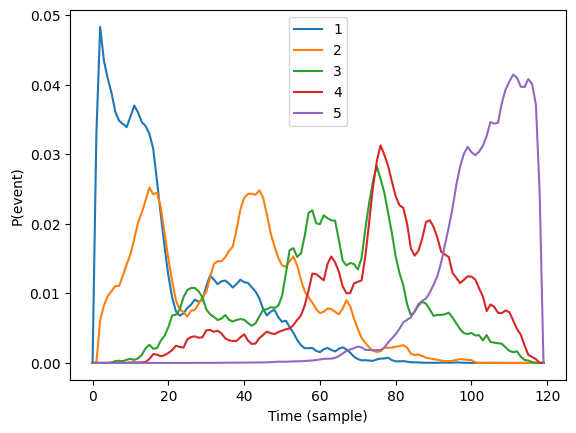

6 None
Estimating 5 events model
parameters estimated for 5 events model


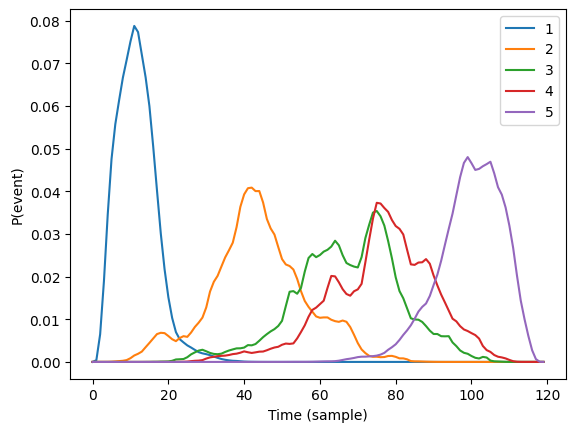

6 0.4
Estimating 5 events model
parameters estimated for 5 events model


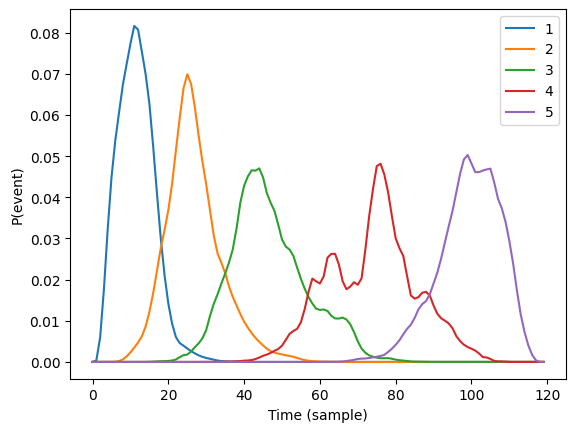

In [45]:
for x in [2, 6]:
    for y in [None, 0.4]:
        print(x, y)
        condition = "C"
        max_events = 5
        estimates = get_estimates(x, y, 200, condition)
        mags, params = get_mags_pars(estimates[1], max_events)

        hmp_data_cond = hmp.utils.condition_selection(hmp_data, epoch_data, condition, variable='event_name')

        init = hmp.models.hmp(hmp_data_cond, epoch_data, event_width=50, cpus=cpus, 
                                shape =                   x,
                                location_corr_threshold = y,
                                location_corr_duration  = 200)

        general_model = general_loocv_model(init, mags, params, max_events)
        plot_event_probs(general_model, max_events)